In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import ipywidgets
import ipywidgets as widgets
from scipy.signal import detrend, savgol_filter, butter,sosfiltfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os     
import pandas as pd
import json

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size']= 12
plt.style.use("seaborn-colorblind")

## Introduction
This notebook allows to analyse force-time data obtained from the Chiaro/Piuma nanoindenters from Optics 11 Life (https://www.optics11life.com/). 
It can analyse time signals acquired in displacement mode (keeping the piezo Z position constant), indentation mode (keeping the actual indentation constant using closed feedback) or load mode (keeping the force constant using closed feedback). However, it has been optimised to analyse data acquired in the first two modes, which allow to perform **stress relaxation** experiments. 
The notebook is divided into several sections that should be ran sequentially, and runs ipywidgets to make it more user friendly for non-programmers (i.e., the user is expected to interact with the notebook using buttons, sliders etc. without touching the code). 

The notebook reads data in the form of a convenient JSON file originating from the NanoPrepare software (time branch): https://github.com/CellMechLab/NanoPrepare/tree/time. The NanoPrepare software is open source and instructions for its use can be foud at: https://www.jove.com/t/63401/experimental-data-analysis-workflow-for-soft-matter. Essentially, NanoPrepare allows to load matrix scans and single indentations from performed experiments, clean the dataset and save cleaned data in a convenient single JSON file that is then read here. 

## Functions
This is the backend that contains functions used throughout the notebook. 
It needs to be ran, but not modified.

In [3]:
def average_curve(arrs):
    """Finds the average array from a list of arrays containing 
    arrays of different lengths."""
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)
    
def find_CP(x,y,zerorange=900):
    """Finds the CP from F-Z curves by auto-thresholding data. 
    Algorithm writteb by Prof Massimo Vassalli and avilable
    at the open source repository: https://github.com/CellMechLab/softmech"""
    deg = 0 
    worky = np.copy(y)
    xtarget = np.min(x) + zerorange*1e-9
    jtarget = np.argmin( np.abs(x-xtarget) )

    #which direction?
    if x[0]<x[-1]:
        xlin = x[:jtarget]
        ylin = worky[:jtarget]
        m,q = np.polyfit(xlin,ylin,1)
    else:
        xlin = x[jtarget:]
        ylin = worky[jtarget:]
        m,q = np.polyfit(xlin,ylin,1)

    worky = worky-m*x-q

    differences = (worky[1:]+worky[:-1])/2
    midpoints = np.array(list(set(differences)))
    midpoints.sort()

    crossings = []
    for threshold in midpoints[midpoints>0]:
        crossings.append( np.sum( np.bitwise_and( (worky[1:]>threshold),(worky[:-1]<threshold) )))
    crossings=np.array(crossings)

    inflection = midpoints[midpoints>0][np.where(crossings==1)[0][0]]
    jcpguess = np.argmin( np.abs(differences-inflection) )+1

    xcp = x[jcpguess]
    ycp = y[jcpguess]
    return [xcp, ycp]
  
def linear(x,a,b):
    """"Linear function."""
    return a*x +b

def sls_model(x,E_1,E_2,tau):
    """Standard linear solid (SLS) model. 
    Ref (DOI): 10.1039/c9sm01020c """
    C = (4.0 * np.sqrt(R) * delta_0**(3/2))/(3.0*(1-nu**2)) #Hertzian constant
    E_t = E_2*np.exp(-x/tau)  #Relaxation modulus (One exponential)
    return C * (E_1 + E_t)

def prony_model(x,E_1,E_2,E_3,tau2,tau3):
    """Generalised model with two exponentials (Prony).
    Ref (DOI): 10.1039/c9sm01020c"""
    C = (4.0 * np.sqrt(R) * delta_0**(3/2))/(3.0*(1-nu**2)) #Hertzian constant
    E_t = E_2*np.exp(-x/tau2) + E_3*np.exp(-x/tau3) #Relaxation modulus (Prony Series with two terms) 
    return C * (E_1+E_t)

def do_fit(model,xdata,ydata,guess=None):
    """Fits data based on a given model."""
    xdata=np.asarray(xdata)
    ydata=np.asarray(ydata)
    popt, pcov = curve_fit(model,xdata,ydata,maxfev=10000,p0=guess)
    xdata=np.linspace(min(xdata),max(xdata),1000)
    return [xdata, model(xdata,*popt)]

def linear_detrend(tdata,fdata,start_trend=5.0,end_trend=40.0):
    """Applies a linear detrend filter to F-t data in case of thermal drift."""
    #Isolate drifted signal
    start = np.argmin((tdata-start_trend)**2) #end of fast relaxation
    end = np.argmin((tdata-end_trend)**2) #end of signal 
    fdata_drift = fdata[start:end]
    tdata_drift = tdata[start:end]
    popt,pcov=curve_fit(linear,tdata_drift,fdata_drift)
    time_all = np.linspace(min(tdata),max(tdata),len(tdata))
    fmodel = linear(time_all,*popt)
    de_drifted = fdata-fmodel
    return de_drifted,popt

## Input Data 
Below, input the path to the cleaned JSON file originating from the NanoPrepare complementary software. 
Also, input the spring constant (k) in N/m of the used cantilever. 

In [4]:
dirw=widgets.Text(
    value='',
    placeholder='Please enter the files directory',
    description='Directory:',
    disabled=False
)
display(dirw)

cantilever_k = widgets.FloatText(
    value=0.5,
    description='k (N/m):',
    disabled=False
)
display(cantilever_k)

Text(value='', description='Directory:', placeholder='Please enter the files directory')

FloatText(value=0.5, description='k (N/m):')

## Find initial indentation depth 
If measurements are performed in displacement (Z) control, the indentation depth will increase as the force relaxes (indentation = Z - F/k after the contact point; where Z is constant and F decays). This drift is generally negligible but can be corrected for by taking the average of the indentation over time after the maximum force is reached (https://doi.org/10.1115/1.3194752) - which is not addressed here.  If measurements are performed in indentation control mode, the indentation is kept constant at the initial indentation throughout the duration of the experiment; and no correction is needed.  
Below, an overview of the dataset is given: the first graph shows force v displacement ($F-Z$); the second graph shows force v indentation ($F-\delta$) data; where $\delta$ is calculated by finding the contact point, which can be tweaked with the "set_to_zero" slider. The third graph shows the evolution of the indentation in time after the contact point for individual curves (black) and on average (red). The last graph shows the histogram of the initial indentation depth, which can be compared to the final indentation depth on graph 3 (red).

In [5]:
k = cantilever_k.value #N/m
f = open(dirw.value)
data = json.load(f)
indentation = []
time = []
def zero_plot(set_to_zero=900):
    min_ind=[] #the minimum indentation (initial indentation)
    fig,ax=plt.subplots(1,4,figsize=(12,3))
    for i in range(len(data['curves'])):
        for_force = np.array(data['curves'][i]['data']['F']) #for = forward segment, units of loaded data are N
        for_Z = np.array(data['curves'][i]['data']['Z'])  #for = forward segment, units of laoded data are m
        raw_time = np.array(data['curves'][i]['raw_data']['raw_time']) #s
        raw_force = np.array(data['curves'][i]['raw_data']['raw_force'])* 1e-6/1e3 # multiply by 1e-6 and divide by 1e3 because units of loaded data are um*1e3
        raw_Z = np.array(data['curves'][i]['raw_data']['raw_z']) *1e-9 # #multiply by 1e-9 because units of loaded data are nm

        #Offset F-z forward curves
        if for_force is not None and len(for_force)>0:
            for_off = for_force[0]
            raw_force_off = raw_force[0]
            if for_off <0: 
                for_force = for_force-for_off
                raw_force = raw_force-raw_force_off

            #find the CP 
            z0,f0 = find_CP(for_Z,for_force,set_to_zero)

            #forward segment 
            ind = for_Z[np.argmin((for_Z-z0)**2)::]-z0
            f_ind=for_force[np.argmin((for_force-f0)**2)::]-f0

            #Whole signal as a function of time 
            Z_from_CP = raw_Z[np.argmin((for_Z-z0)**2)::]-z0 #Z from CP as a function of time
            f_from_CP = raw_force[np.argmin((for_force-f0)**2)::]-f0 #F from CP as a function of time
            t_from_CP = raw_time[np.argmin((for_force-f0)**2)::] #time from CP

            ax[0].plot(for_Z-z0,for_force, lw=0.1,c='k')

            if len(ind)==len(f_ind):
                #sometimes ind and f_ind do not have the same length (probably something due to cp algorithm)
                ind_from_CP = Z_from_CP - f_from_CP/k #z-F/k, so it should increase if F is relaxing and Z is constant 
                indentation.append(ind_from_CP) 
                time.append(t_from_CP)
                ax[1].plot(ind,f_ind, lw=0.1,c='k')
                ax[2].plot(t_from_CP,ind_from_CP,lw=0.05,c='k')
                min_ind.append(max(ind))

        t_av, _ = average_curve(time)
        ind_av,ind_av_err = average_curve(indentation)
    
    print(f'average initial indentation (m): {(np.mean(min_ind))}')
    ax[2].plot(t_av,ind_av,color='r', lw=1)
    ax[3]=sns.histplot(min_ind,kde='true',alpha=0.5)
    ax[0].set_xlabel('$z-z_0$ (m)')
    ax[1].set_xlabel('$\delta$ (m)')
    ax[2].set_xlabel('t (s)')
    ax[0].set_ylabel('$F$ (N)')
    ax[1].set_ylabel('$F$ (N)')
    ax[2].set_ylabel('$\delta$ (m)')
    ax[3].set_title('initial $\delta$ (m)')
    fig.tight_layout()
    plt.show()
plotzerow=widgets.interactive(zero_plot,set_to_zero=(500,2000,0.5))
display(plotzerow)

interactive(children=(FloatSlider(value=900.0, description='set_to_zero', max=2000.0, min=500.0, step=0.5), Ou…

## Screening 
The plot below allows to select four thresholds for removing bad time data and aligning time data. This section is used only to selct the thresholds; the actual data is thresholded in the next section (**Adjusting**) if the "Threshold" checkbox is ticked. The data can be thresholded based on the following thresholds: 

1. tmin (s): the time under which the maximum force should occur. Any curve whose maximum force occurs after this time is discarded from the analysis. 
2. tmax (s): the maximum time one wants to display and analyse the data for. This is used to essentially remove the ramping down of the stress relaxation curve. Alla data points after this time are discarded.
3. fmin (uN): the minimum acceptable value for the maximum (peak) force. Any curve whose maximum force is smaller than fmin will be discarded.
4. fmax (uN): the maximum acceptable value for the maximum (peak) force. Any curve whose maximum force is greater than fmax will be discarded.

tip: adjust the sliders by typing the approximate value for the variable in the box next to the slider and click enter on your keyboard. Just sliding will update the plot for each value the slider passes through, resulting in a laggy visual update.

In [6]:
f = open(dirw.value)
data = json.load(f)
def first_plot(tmin=0.5,tmax=30.0,fmin=0.0,fmax=50.0):
    fig,ax=plt.subplots(1,1,figsize=(10,5))
    tall = []
    fall = []
    for i in range(len(data['curves'])):
        raw_time = np.array(data['curves'][i]['raw_data']['raw_time'])
        raw_force = np.array(data['curves'][i]['raw_data']['raw_force'])

        #Offset force-time curves 
        off = raw_force[0] #first point
        #if forst point is negative, align
        if off <0: 
            raw_force = raw_force-off
    
        ax.plot(raw_time,raw_force,alpha=1,lw=0.1,c='k')
        ax.axhline(fmin,c="salmon",lw=1)
        ax.axhline(fmax,c="salmon",lw=1)
        ax.axvline(tmax,lw=1)
        ax.axvline(tmin,lw=1)
    ax.set_xlabel('$t$ (s)')
    ax.set_ylabel('$F$ (uN)')
    fig.tight_layout()
    plt.show()
plot1w=widgets.interactive(first_plot,tmin=(0.0,50.0,0.5), tmax=(0.0,120.0,0.5),fmin=(0.0,1000.0,0.1),fmax=(0.0,4000.0,0.1))
display(plot1w)

interactive(children=(FloatSlider(value=0.5, description='tmin', max=50.0, step=0.5), FloatSlider(value=30.0, …

## Adjusting
Now click the "Threshold" checkbox below to apply the above-specified thresholds to the data.

Given the above specified thresholds, the code below finds the maximum force and corresponding time and aligns this value to 0. All curves should now start from t=0. Note that the maximum time displayed will be different from the one selected above as curves are shifted by the time at which the maximum force occurs (however relative time interval is preserved)!


In [7]:
thresholdw=widgets.Checkbox(
    value=False,
    description='Threshold data',
    disabled=False
)

display(thresholdw)

Checkbox(value=False, description='Threshold data')

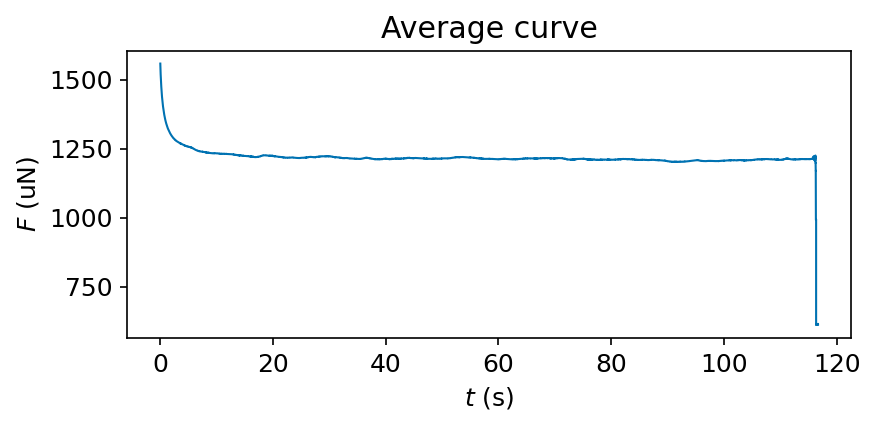

In [8]:
#Widget parameters (Global thresholds)
t_min=plot1w.kwargs["tmin"] #time under which max force should occur (s)
t_max=plot1w.kwargs["tmax"] #max time to display and analyse data for (s)
f_min=plot1w.kwargs["fmin"] #The minium acceptable value for the max force (uN)
f_max = plot1w.kwargs["fmax"]#The maximum acceptable value for the max force (uN)

#Variables to store
tall = []
fall = []
fnormall=[]

fig,ax = plt.subplots(1,1,figsize=(6,3))
for i in range(len(data['curves'])):
    raw_time = np.array(data['curves'][i]['raw_data']['raw_time'])
    raw_force = np.array(data['curves'][i]['raw_data']['raw_force'])
    
    #Offset force-time curves 
    off = raw_force[0] #first point
    #if forst point is negative, align
    if off <0: 
        raw_force = raw_force-off
        
    #Clean data based on user-selected thresholds
    #NB: to be applied on raw data 
    fmax = max(raw_force)
    imaxf = np.argmin((raw_force-fmax)**2)
    if thresholdw.value is True:
        if (fmax > f_max) or (fmax < f_min) or raw_time[imaxf] > t_min:
            continue 
    #Align data to 0 and slice to user-selcted max time
    itmax =np.argmin((raw_time-t_max)**2)
    t=raw_time[imaxf:itmax]-raw_time[imaxf]
    f=raw_force[imaxf:itmax]
    #Normalise force
    fnorm=f/max(f) 
    tall.append(t)
    fall.append(f)
    fnormall.append(fnorm)
ax.set_title("Average curve")
ax.set_xlabel('$t$ (s)')
ax.set_ylabel('$F$ (uN)')

#Find and plot the average curve
t_av,_=average_curve(tall) #time
f_av, f_err = average_curve(fall) #force and its error
f_av_norm=f_av/max(f_av) #normalised average force
_,f_err_norm=average_curve(fnormall) #average normalised force error 
ax.errorbar(t_av,f_av,lw=1,ls='-',alpha=1) 
fig.tight_layout()
plt.show()

Due to the nature of the algorithm employed to find the average curve, the last portion of the curve contains numerical noise.This can be removed using the following slider, to be placed just before the noise starts: 

In [9]:
def cut_average_curve(cut_time=50.0):
    fig, ax = plt.subplots(1,1,figsize = (6,3))
    ax.plot(t_av,f_av)
    ax.axvline(cut_time,color='r')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Force (uN)')
    fig.tight_layout()
plot2w=widgets.interactive(cut_average_curve,cut_time=(0.0,200.0,0.1))
display(plot2w)

interactive(children=(FloatSlider(value=50.0, description='cut_time', max=200.0), Output()), _dom_classes=('wi…

Now that the cutting threshold has been selected, run the cell below to display the final average curve:

Text(0, 0.5, 'Force (uN)')

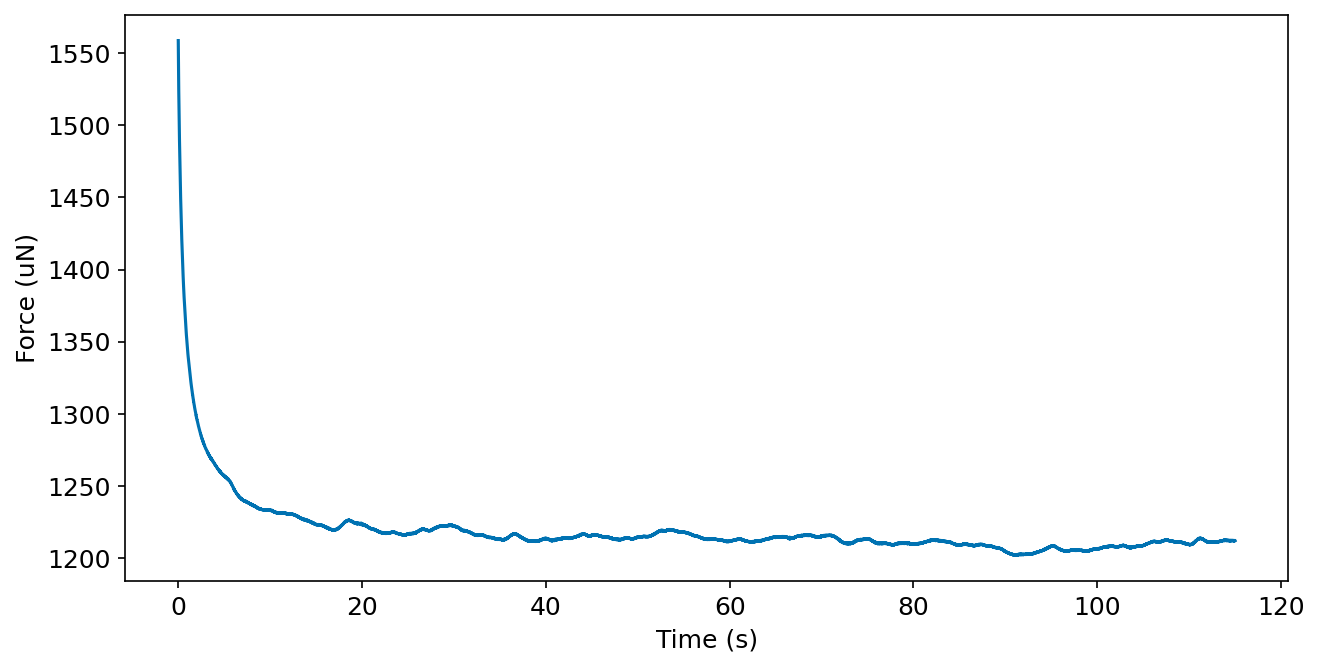

In [10]:
t_cut = plot2w.kwargs['cut_time']
i_t_cut = np.argmin((t_av-t_cut)**2)
t_av = t_av[:i_t_cut]
f_av=f_av[:i_t_cut]
f_err=f_err[:i_t_cut]
f_av_norm=f_av_norm[:i_t_cut]
f_err_norm=f_err_norm[:i_t_cut]
fig, ax = plt.subplots(1,1,figsize = (10,5))
ax.plot(t_av,f_av)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Force (uN)')

If the average curve has an upwards trend (temperature drift), detrend data:

In [11]:
detrendw=widgets.Checkbox(
    value=False,
    description='Detrend data',
    disabled=False
)

display(detrendw)
detrend_range = widgets.FloatRangeSlider(
    value=[10.0, 60.0],
    min=0,
    max=50.0,
    step=0.1,
    description='Detrend Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
display(detrend_range)

Checkbox(value=False, description='Detrend data')

FloatRangeSlider(value=(10.0, 50.0), continuous_update=False, description='Detrend Range:', max=50.0, readout_…

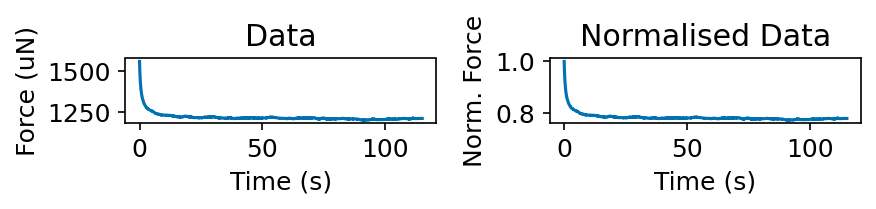

In [12]:
fig,axs = plt.subplots(1,2,figsize=(6,1.5))
if detrendw.value is True: 
    #average curve (absolute)
    f_av_detrended,optd = linear_detrend(t_av,f_av,start_trend=detrend_range.value[0],end_trend=detrend_range.value[1]) 
    f_av_detrended = f_av_detrended+optd[1] #add back y intercept for correct f scaling
    f_av = f_av_detrended
    f_av_norm = f_av/max(f_av)
    #error (absolute)
    f_err_detrended,optd = linear_detrend(t_av,f_err,start_trend=detrend_range.value[0],end_trend=detrend_range.value[1]) 
    f_err_detrended = f_err_detrended+optd[1]
    f_err=f_err_detrended
    #error (from normalised curves)
    f_err_detrended_norm,optd = linear_detrend(t_av,f_err_norm,start_trend=detrend_range.value[0],end_trend=detrend_range.value[1]) 
    f_err_detrended_norm = f_err_detrended_norm+optd[1]
    f_err_norm=f_err_detrended_norm
    
axs[0].plot(t_av,f_av)
axs[1].plot(t_av,f_av_norm)
axs[0].set_title("Data")
axs[1].set_title("Normalised Data")
axs[0].set_xlabel("Time (s)")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Force (uN)")
axs[1].set_ylabel("Norm. Force")
fig.tight_layout()

## Fitting data
Fit average curve with relaxation model. This can be a Standard linear solid (SLS) or Prony series; i.e. a generalised maxwell model with two relaxation times, see for example https://pubs.rsc.org/en/content/articlelanding/2020/sm/c9sm01020c or https://pubs.rsc.org/en/content/articlelanding/2020/bm/c9bm01339c).
The SLS model has 3 fitting parameters ($E_1$, the long term elastic modulus - $E_2$, the relaxation modulus - and its associated time constant, $\tau_2$).
The prony series model has 4 fitting parameters ($E_1$, the long term elastic modulus - $E_2$ and $E_3$, the relaxation moduli - and their associated time constants, $\tau_2$ and $\tau_3$).
The user needs to enter the Poisson's ratio, the tip radius and the approximate constant indentation depth; as Hertzian contact is still assumed. After, the user is prompted with what model to fit the average curve.

In [13]:
poisson = widgets.BoundedFloatText(
    value=0.5,
    min=0,
    max=1.0,
    step=0.1,
    description='Poisson\'s:',
    disabled=False
)
display(poisson)

radius = widgets.BoundedFloatText(
    value=3,
    min=1,
    max=250,
    step=0.5,
    description='$R$ (um):',
    disabled=False
)
display(radius)

#delta_0 does not impact on the estimation of the relaxation times
ind_0 = widgets.BoundedFloatText(
    value=3,
    min=1,
    max=250,
    step=0.5,
    description='$\delta_0$ (um):',
    disabled=False
)
display(ind_0)

chosen_model = widgets.Dropdown(
    options=['SLS', 'Prony'],
    value='Prony',
    description='Model:',
    disabled=False,
)
display(chosen_model)

BoundedFloatText(value=0.5, description="Poisson's:", max=1.0, step=0.1)

BoundedFloatText(value=3.0, description='$R$ (um):', max=250.0, min=1.0, step=0.5)

BoundedFloatText(value=3.0, description='$\\delta_0$ (um):', max=250.0, min=1.0, step=0.5)

Dropdown(description='Model:', index=1, options=('SLS', 'Prony'), value='Prony')

[1.60474821e-02 3.13275612e-03 9.20311694e-04 8.69599951e-01
 9.82505473e+00]


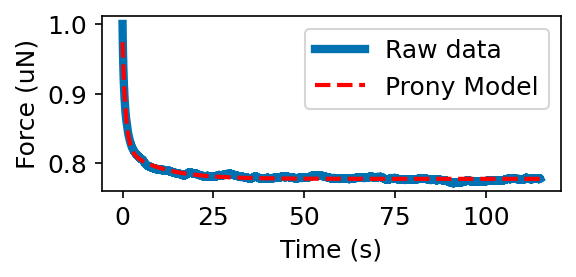

In [14]:
nu = poisson.value
R = radius.value
delta_0 = ind_0.value
fig,ax=plt.subplots(1,1,figsize=(4,2))
if chosen_model.value=="Prony":
    model_name = "Prony"
    seed = [f_av_norm[-1],(f_av_norm[-1]+f_av_norm[0]),(f_av_norm[-1]+f_av_norm[0]),0.1,10.0]
    popt,pcov = curve_fit(prony_model,t_av,f_av_norm,p0=seed,maxfev=100000) #method='trf', #loss="soft_l1"
    perr = np.sqrt(np.diag(pcov))
    ax.plot(t_av,f_av_norm,lw=4,label="Raw data")
    ax.plot(t_av,prony_model(t_av,*popt),'--',c='r',lw=2,label=model_name +" Model")
    norm_model=prony_model(t_av,*popt)
if chosen_model.value=="SLS":
    model_name = "SLS"
    seed = [f_av_norm[-1],(f_av_norm[-1]+f_av_norm[0]),10.0]
    popt,pcov = curve_fit(sls_model,t_av,f_av_norm,p0=seed,maxfev=100000) #method='trf', #loss="soft_l1"s
    perr = np.sqrt(np.diag(pcov))
    ax.plot(t_av,f_av_norm,lw=4,label="Raw data")
    ax.plot(t_av,sls_model(t_av,*popt),'--',c='r',lw=2,label=model_name+" Model")
    norm_model=sls_model(t_av,*popt)
print(popt)
plt.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Force (uN)")
fig.tight_layout()

Final plot to save for representative purposes:

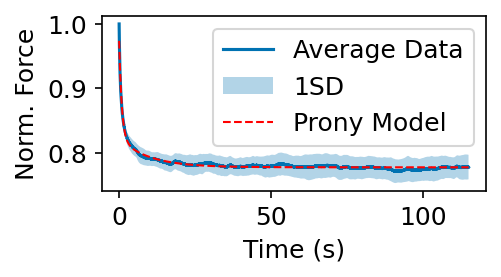

In [15]:
fig,ax=plt.subplots(1,1,figsize=(3.5,2))
ax.plot(t_av,f_av_norm,label="Average Data")
ax.fill_between(t_av,f_av_norm-0.5*f_err_norm,f_av_norm+0.5*f_err_norm,alpha=0.3,label="1SD")
ax.plot(t_av,norm_model,'--',c='r',lw=1,label=model_name+" Model")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Norm. Force")
plt.legend()
fig.tight_layout()

## Calculating energy dissipation

20.31687709718114
22.216838514033242
24.116799930885346


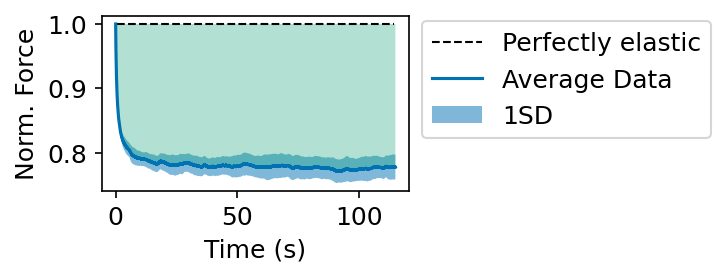

In [52]:
fig,ax=plt.subplots(1,1,figsize=(5,2))
ax.axhline(1,xmin=0.05,xmax=0.95,color='k',lw=1,label='Perfectly elastic',ls='--')
ax.plot(t_av,f_av_norm,label="Average Data")
f_err_min = f_av_norm-0.5*f_err_norm
f_err_max = f_av_norm+0.5*f_err_norm
ax.fill_between(t_av,f_err_min,f_err_max,alpha=0.5,label="1SD")
ax.fill_between(t_av,f_av_norm[0],f_av_norm,alpha=0.3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Norm. Force")
plt.legend(bbox_to_anchor=(1, 1.04))
fig.tight_layout()
av_en_dissipated = f_av_norm[0]-f_av_norm[-1]
max_en_dissipated = f_av_norm[0]-f_err_min[-1]
min_en_dissipated = f_av_norm[0]-f_err_max[-1]
sd = (f_err_max[-1] - f_err_min[-1])
print(min_en_dissipated*100)
print(av_en_dissipated*100)
print(max_en_dissipated*100)

In [ ]:
#Extract time at which force reaches % of original value (specified above)
F_TARGET=relaxation_timew.value*(max(f_av_norm)) 
i_fclose = np.argmin((f_av_norm-F_TARGET)**2) 
t_target=t_av[i_fclose]
print(f"The time for which the stress relaxes to {(relaxation_timew.value*100.0)}% of the original value is {t_target} s!")

def plot_average(): 
    fig,ax=plt.subplots(1,1,figsize=(5,2))
    ax.semilogx(t_av,f_av_norm,zorder=-1)
    ax.scatter(t_target,f_av_norm[i_fclose],c='red',zorder=1,alpha=0.5)
    ax.set_xlabel('$t$ (s)')
    ax.set_ylabel('Normalised force')
    plt.show()
    
widgets.interactive(plot_average)

 ## Saving data
 The cell below saves the data from the average curve in a .tsv file, together with the fitted model and best model parameters:

In [ ]:
savingfolderw=widgets.Text(
    placeholder='Output folder',
    disabled=False
)
boxw1=widgets.HBox([widgets.Label(value="Output Folder"), savingfolderw])
display(boxw1)

samplenamew=widgets.Text(
    placeholder='Please enter the sample name',
    disabled=False
)
boxw2=widgets.HBox([widgets.Label(value="Sample Name"), samplenamew])
display(boxw2)

In [ ]:
fname=savingfolderw.value+"/"+samplenamew.value +".tsv"
with open(fname,"w") as f: 
    f.write("Exported stress relaxation analysis \n")
    f.write("Sample Name: {} \n".format(samplenamew.value))
    f.write("Time for Energy Dissipation (s): %.2f \n"%(t_av[-1]))
    f.write("Average Energy Dissipated: {} \n".format(av_en_dissipated*100.0))
    f.write("SD Energy Dissipated: {} \n".format(sd*100.0))
    # f.write("Max Energy Dissipated: {} \n".format(max_en_dissipated*100.0))
    # f.write("Min Energy Dissipated: {} \n".format(min_en_dissipated*100.0))
    f.write("Fitted model: {} \n".format(model_name))
    f.write("Number of points: {}\n".format(len(data['curves'])))
    if model_name == "Prony":
        f.write("Model tau_2 (s) {} pm {} \n".format(popt[3],perr[3]))
        f.write("Model tau_3 (s) {} pm {} \n".format(popt[4],perr[4]))
    if model_name =="SLS":
        f.write("Model tau_1 (s) {} pm {} \n".format(popt[2],perr[2]))
    f.write('Avg time [s] \t Avg Norm Force \t Error Force \t Normalised Model \n')
    for x in zip(*[t_av,f_av_norm,f_err_norm,norm_model]):
                 f.write("{0}\t{1}\t{2}\t{3}\n".format(*x))